# Exercises

## Exercise 1
---

You can find below the code that was used to generate the activity of place cells on a linear track.
Use the code and the decoding procedure you lerned about in the lesson to explore how different features of the data impact our ability to decode position.
In particular:

A - Try to use different fractions of our data samples. How does the median error change when the the number of available sample gets larger? You do not need to re-generate any data, just randomly sub-sample the data to different fractions.

B - How many place cells do we need to reliably decode position? Try to re-do the decoding using only 10 cell, then 20, and so on. How does the median error change? Does it reach an asymptote? (Also in this case, you do not need to re-generate the data, you can just select a random subset of cells each time)

C - Generate new data using the code below, changing the firing rate noise (changing the value of the variable `noise firing_rate`). How does this noise impact the decoding? 

## Exercise 2
---
In the loop implementation of the decoder, we used `poisson.logpmf(k,mu)` to calculate the log probability of observing $k$ spikes given an average firing rate of $\mu$. 
This is mathematically equivalent to `np.log(poisson.pmf(k,mu))`, in which we calculate the probability, and then take the log.


Re-run the decoding substituting this expression:

```
posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
```

To the line we are using to calculate the posterior.
Do you see any difference in the results? What do you think this is due to?




## Exercise 3
---
A - Estimate the quality of the sequence detection methods we saw in the lesson. How many false poistive does it find? How many false negatives?

B - Investigate the effect of `noise_x_react` and `noise_t_react` on the false positive rate and the false negative rate of our detection procedure.

C - What kind of sequence can our methods detect? What kind of activity, despide being sequential, could escape our detection method? Would you have an idea for a different method for sequence detection?


### Code for data generation

### Exercise 1A



In [1]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import poisson
import seaborn as sns
import tqdm 
%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 5]
from ipywidgets import interact
import ipywidgets as widgets


track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

In [2]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

In [3]:
# GENERATE TRAJECTORY

n_runs = 10
use_stops = False
av_running_speed = 10 # the average running speed (in cm/s)
fps = 10 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])


for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    if use_stops:
        x = np.concatenate((x, stop1, run1, stop2, run2))
    else:
         x = np.concatenate((x, run1, run2))
t = np.arange(len(x))/fps

In [4]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.5 # the baseline noise firing rate
spikes = []

for i in range(n_cells):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)


In [5]:
import pickle

file_name = 'linear_track_data_noisier.pickle' # change this name when you save new data

out_data = {}
out_data['x'] = x
out_data['t'] = t
out_data['spikes'] = spikes
out_data['track_length'] = track_length
out_data['fps'] = fps

with open('data/'+file_name,'wb') as f:
    pickle.dump(out_data,f)

In [6]:
def decode_subsample(fraction_samples, fraction_cells = 1.0, file_name = 'data/linear_track_data.pickle', exercise_2 = False):  
    data_file = file_name
    with open(data_file, 'rb') as handle:
        data = pickle.load(handle)

    x,t,spikes = data['x'].copy(),data['t'].copy(),data['spikes'].copy()
    track_length = data['track_length']
    fps = data['fps'] 
    n_cells = int(len(spikes))
    n_cells = int((fraction_cells*n_cells))
    cells_kept = np.sort(np.random.choice(len(spikes), n_cells, replace = False)).astype('int')
    spikes = [spikes[n] for n in cells_kept]
    for n in range(n_cells):
        indices_kept = np.random.choice(spikes[n].shape[0], int(fraction_samples * (spikes[n].shape[0])), replace = False)
        indices_kept = np.sort(indices_kept)
        spikes[n]= spikes[n][indices_kept]
    
    
    # we compute the poistion at which each spike was emitted
    spike_positions = [np.interp(s, t, x) for s in spikes]
    space_bins = np.arange(0., track_length, 5.) # binning in bins of 5 cms

    # we compute histograms for each cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps

    firing_rate_maps = spikes_hist / occupancy 

    spikes_count= [np.histogram(s,t)[0] for s in spikes]
    spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar (samples x features) shape

    # code decoding

    true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
    decoding_times = t[:-1]

    x_decoded = np.zeros_like(true_x)

    for t_bin in tqdm.trange(len(decoding_times)):
        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
            posterior = np.empty(firing_rate_maps.shape[-1])

            for i in range(len(posterior)):
                # Note that we work with log so that we can sum probabilities
                # instead of multiplying them 
                if exercise_2:
                    posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
                else:
                    posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(10,-15))


            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan  

    plt.figure(figsize=(10,5))
    plt.title(f"{fraction_samples*100}% of samples kept, for {n_cells} cells")
    plt.plot(x_decoded,label= 'decoded x')
    plt.plot(true_x,label = 'true x')
    plt.legend()
    plt.show()
    # error distribution
    mse = np.sqrt((true_x-x_decoded)**2)
    sns.histplot(mse)
    plt.title(f"{fraction_samples*100}% of samples kept")
    plt.axvline(x = np.nanmedian(mse),c='r')
    print(f'Median error: {np.nanmedian(mse)} cm')
    return np.nanmedian(mse)

100%|██████████| 4626/4626 [00:02<00:00, 2196.80it/s]


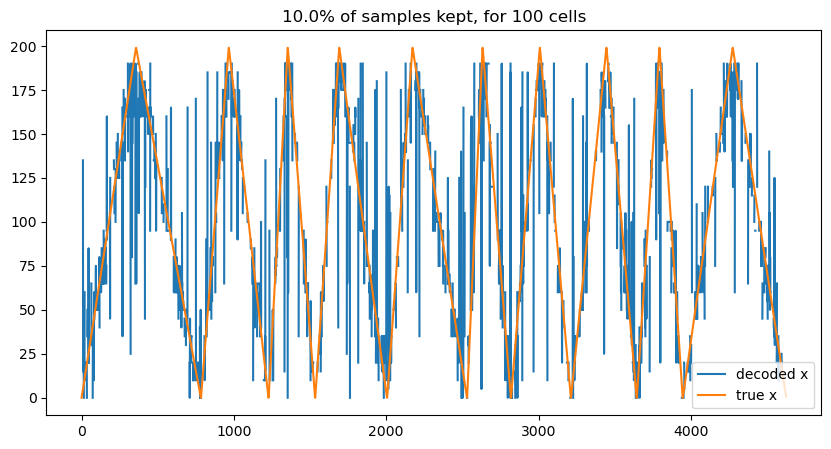

Median error: 7.34978382368449 cm


100%|██████████| 4626/4626 [00:03<00:00, 1165.38it/s]


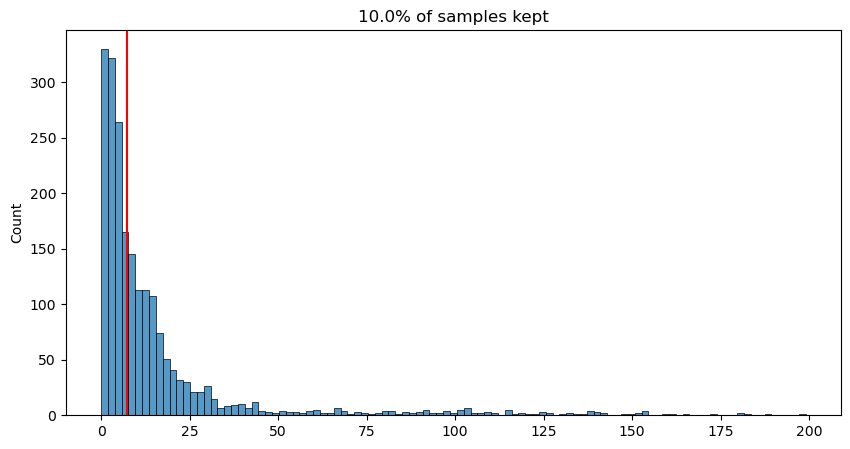

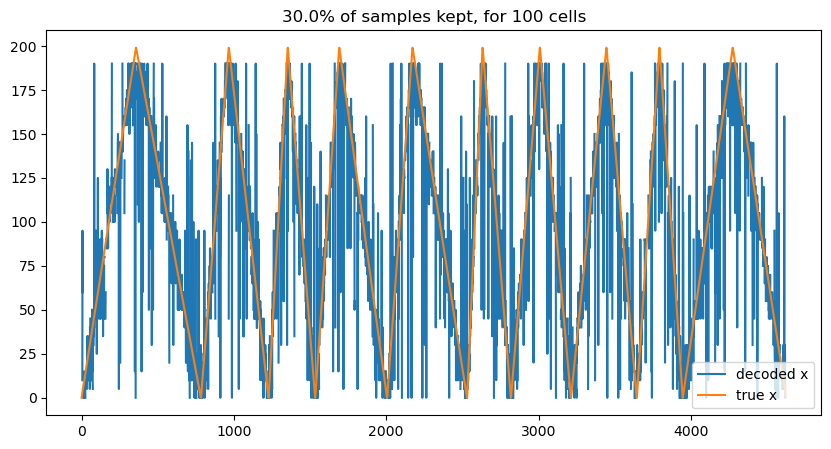

Median error: 5.817891373801928 cm


100%|██████████| 4626/4626 [00:04<00:00, 1032.17it/s]


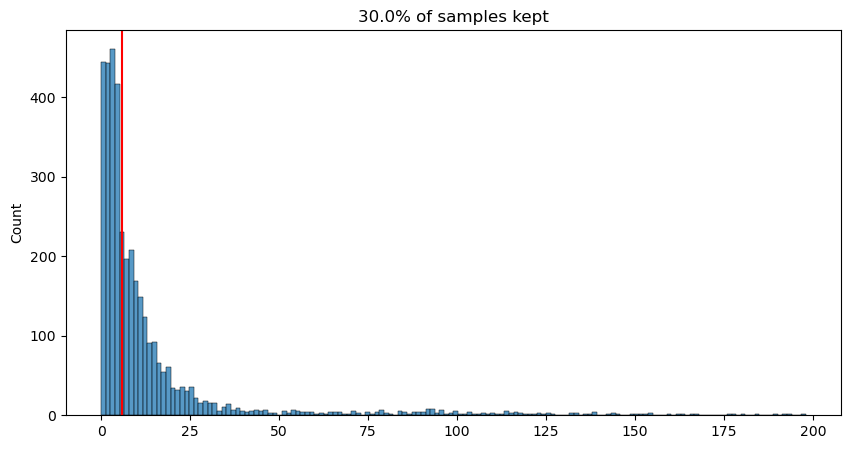

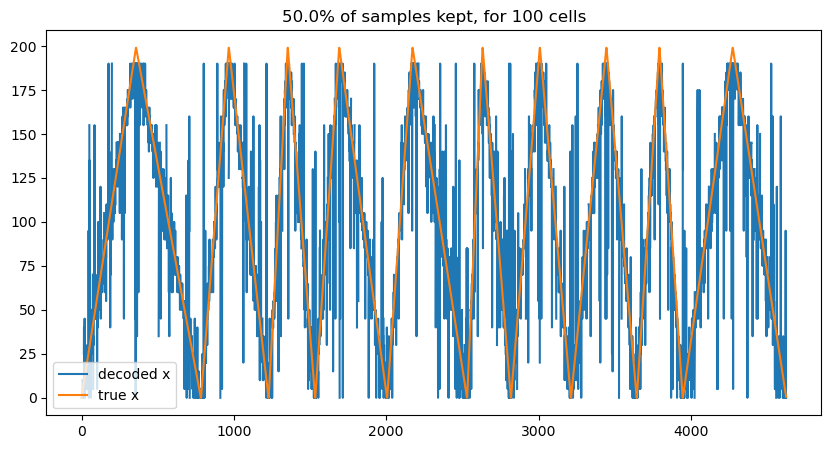

Median error: 4.907692307692315 cm


100%|██████████| 4626/4626 [00:04<00:00, 1001.82it/s]


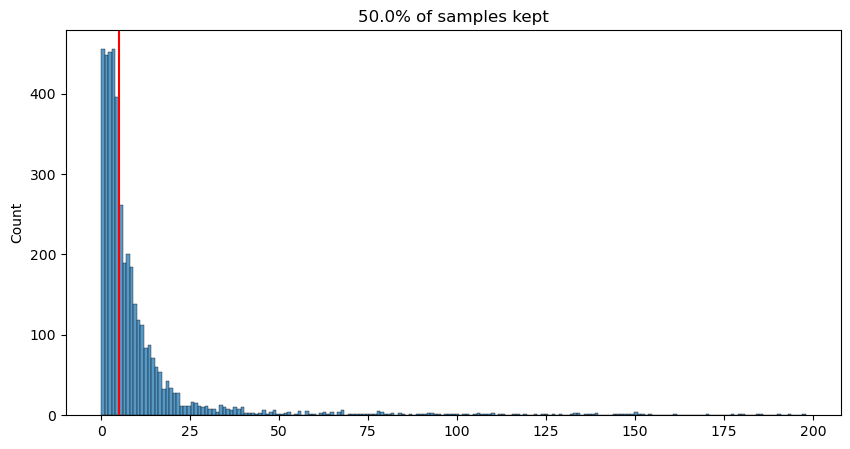

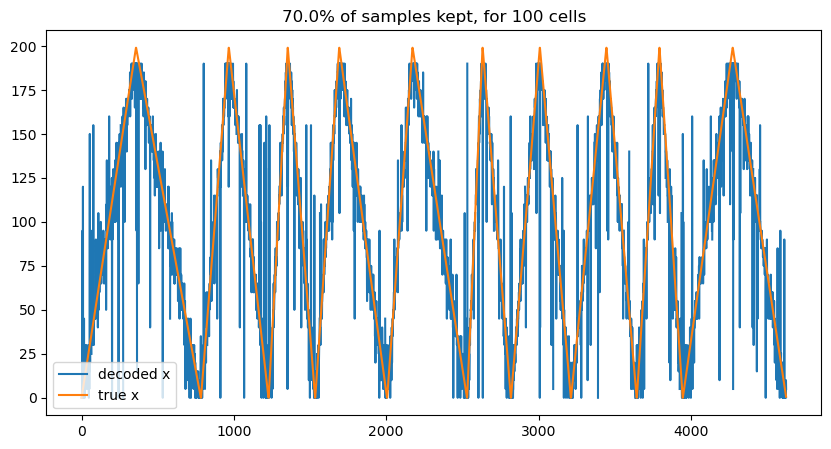

Median error: 4.372549019607845 cm


100%|██████████| 4626/4626 [00:04<00:00, 983.37it/s] 


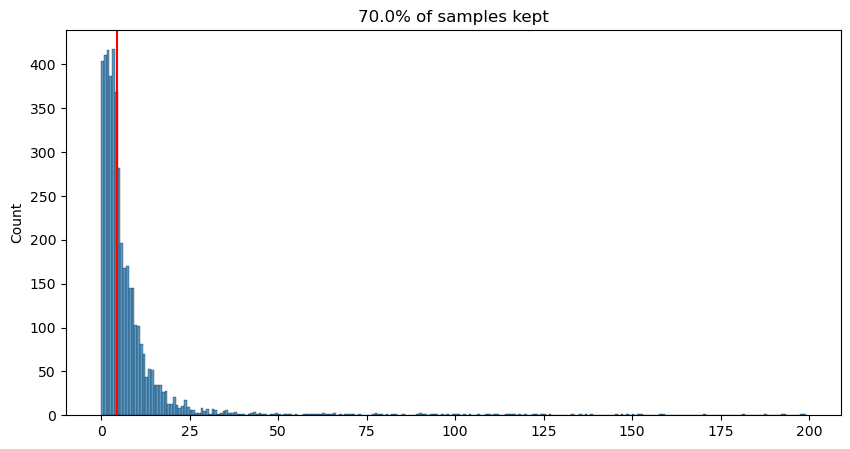

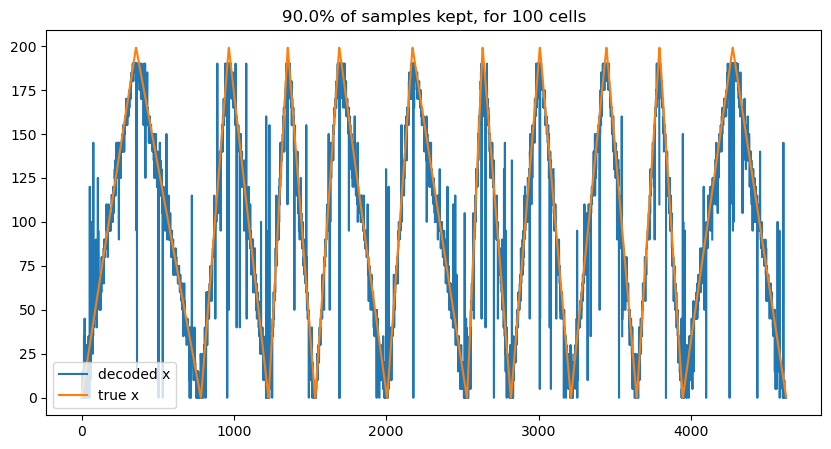

Median error: 3.9159663865546293 cm


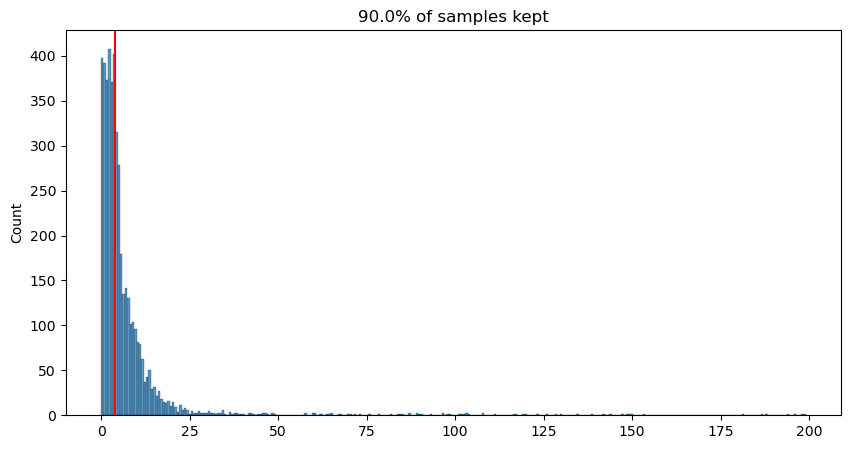

In [7]:
errors = []
fraction_samples = [0.1, 0.3, 0.5, 0.7, 0.9]
for fraction in fraction_samples:
    errors.append(decode_subsample(fraction_samples = fraction))

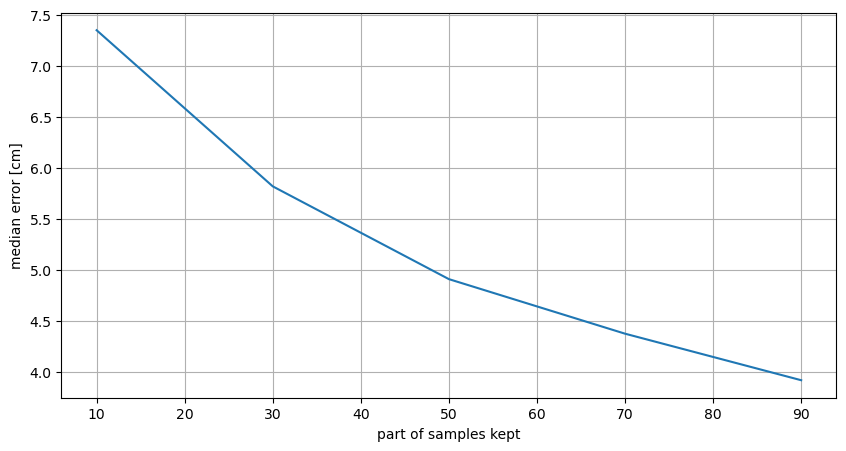

In [8]:
plt.plot(100*np.array(fraction_samples), np.array(errors))
plt.xlabel("part of samples kept")
plt.ylabel("median error [cm]")
plt.grid()

### Discussion:
The effective coarse-graining of the spike trains, makes it more probable to drop spikes that are not due to noise but due to the neuron being activated, thus the SNR goes up, making it harder to predict the exact position.

100%|██████████| 4626/4626 [00:02<00:00, 1943.28it/s]


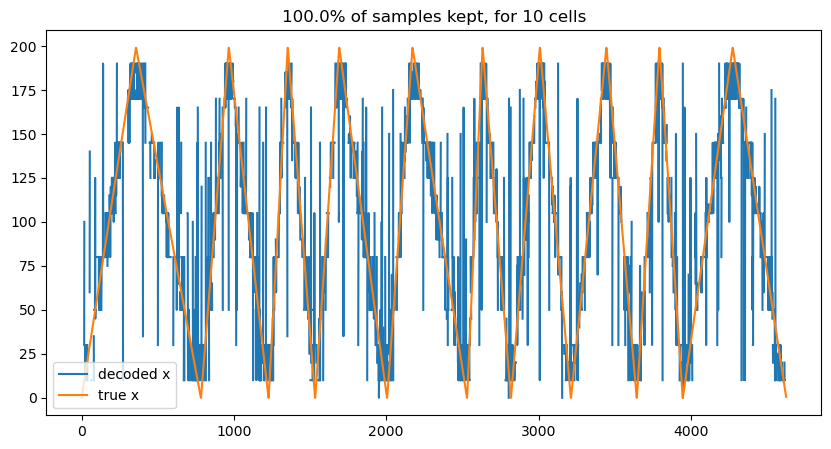

Median error: 8.00897938662645 cm


100%|██████████| 4626/4626 [00:02<00:00, 1749.05it/s]


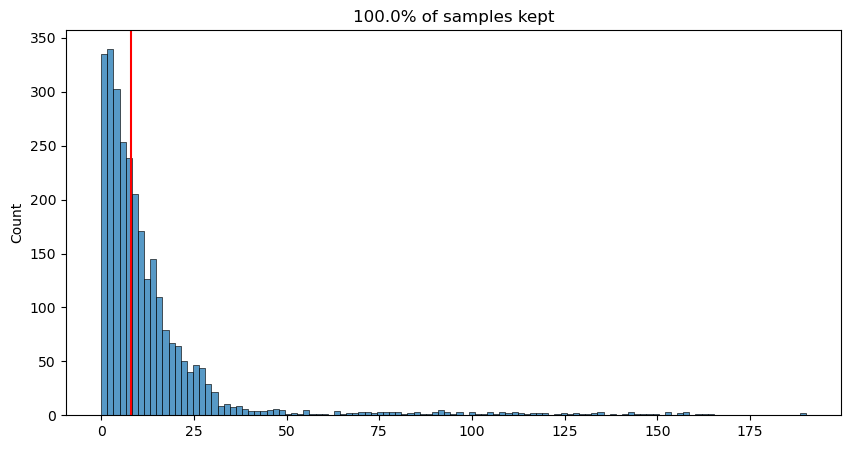

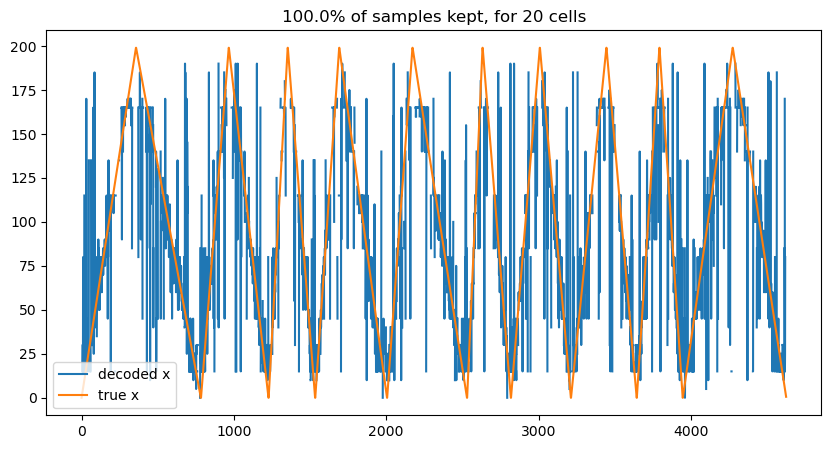

Median error: 7.775294117647064 cm


100%|██████████| 4626/4626 [00:03<00:00, 1415.90it/s]


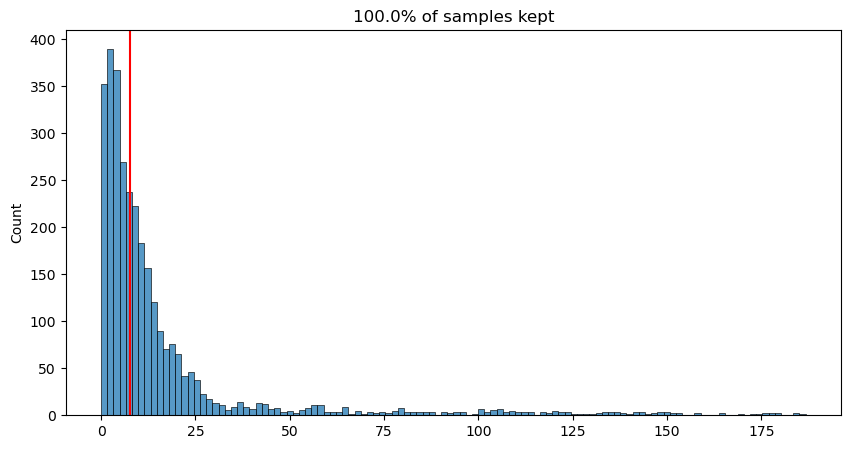

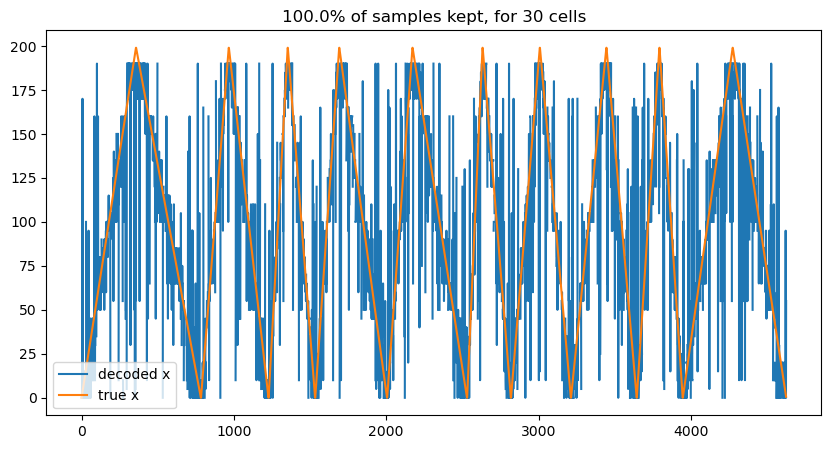

Median error: 6.824175824175796 cm


100%|██████████| 4626/4626 [00:03<00:00, 1216.80it/s]


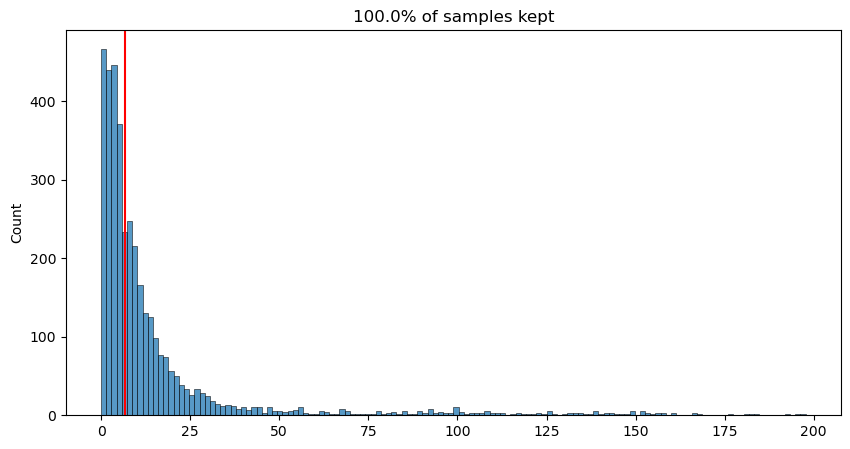

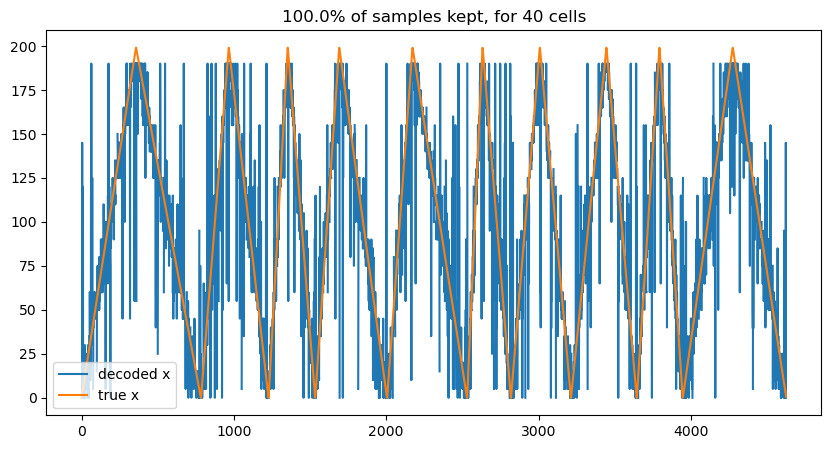

Median error: 6.02271164589601 cm


100%|██████████| 4626/4626 [00:03<00:00, 1166.59it/s]


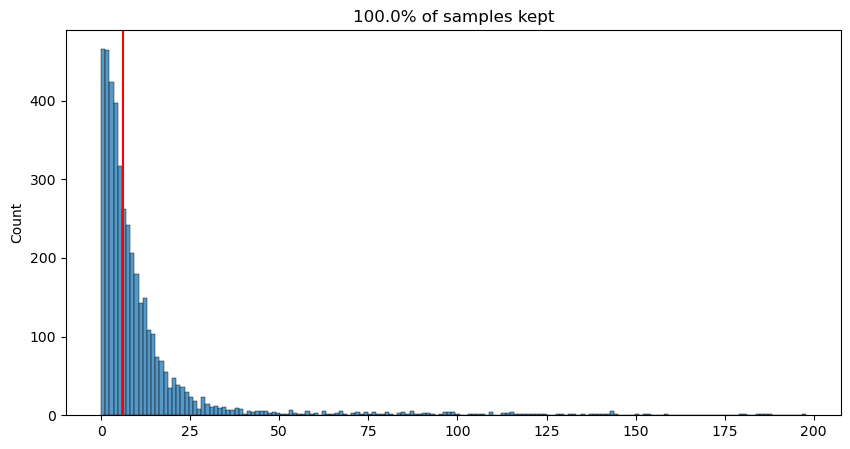

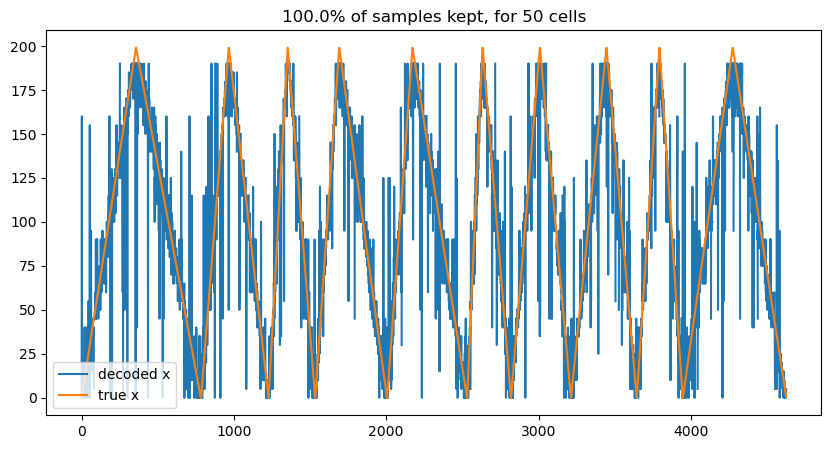

Median error: 5.125 cm


100%|██████████| 4626/4626 [00:03<00:00, 1167.42it/s]


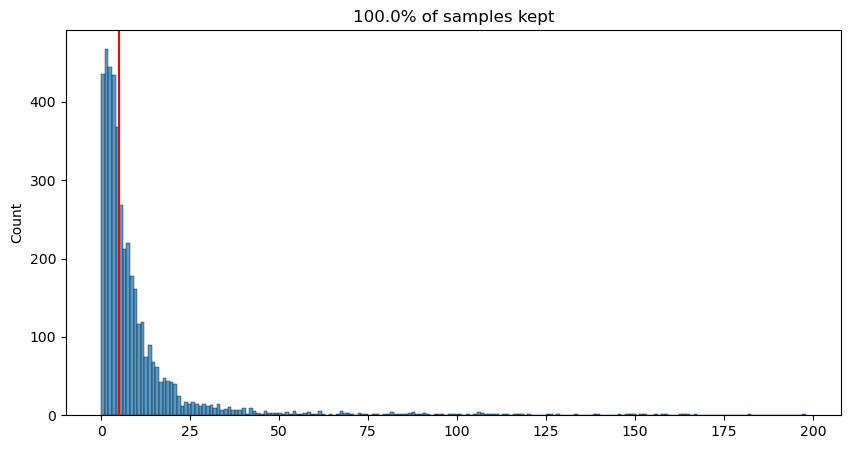

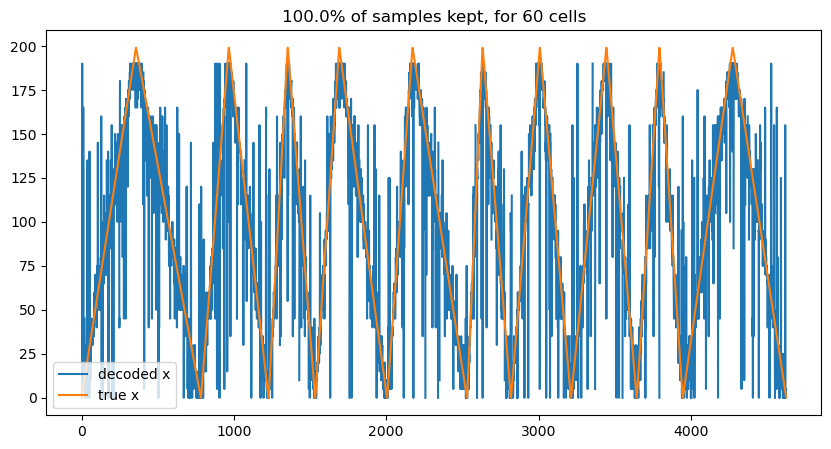

Median error: 4.997536945812811 cm


100%|██████████| 4626/4626 [00:04<00:00, 1064.74it/s]


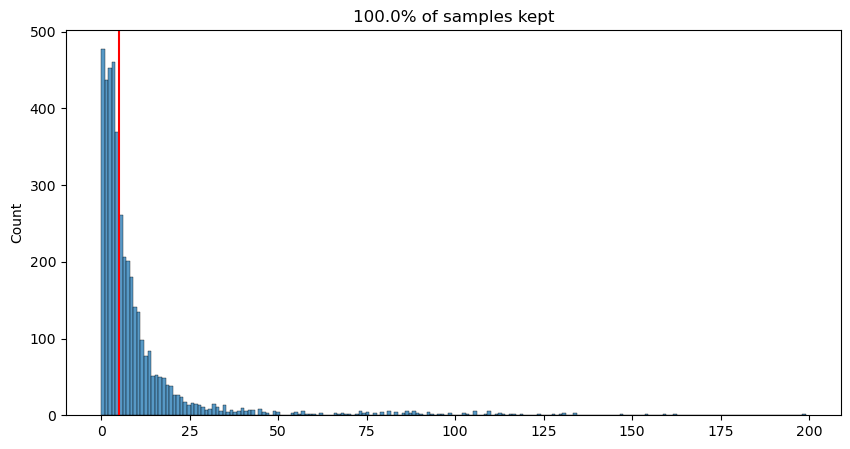

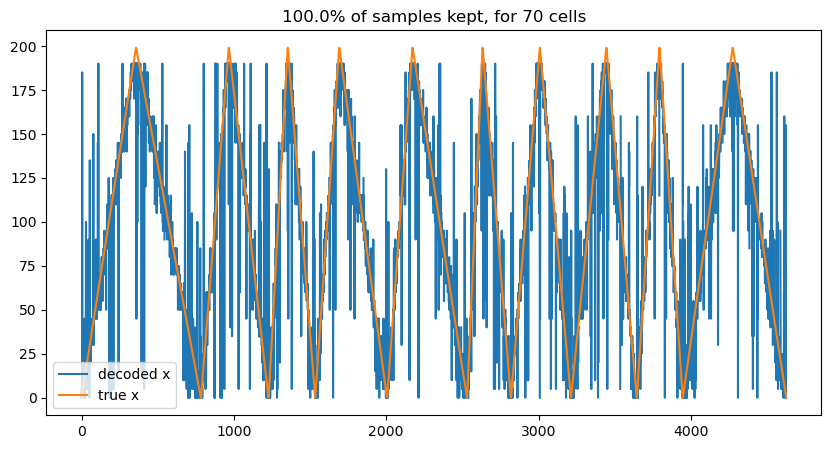

Median error: 4.751999999999999 cm


100%|██████████| 4626/4626 [00:04<00:00, 1075.65it/s]


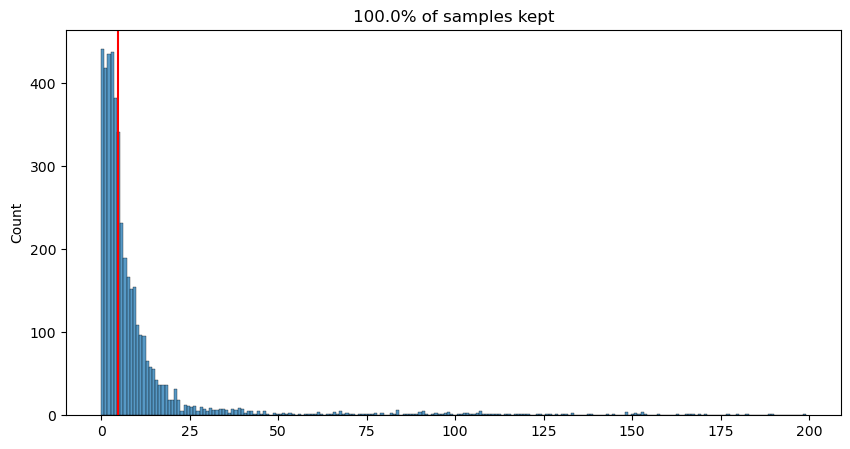

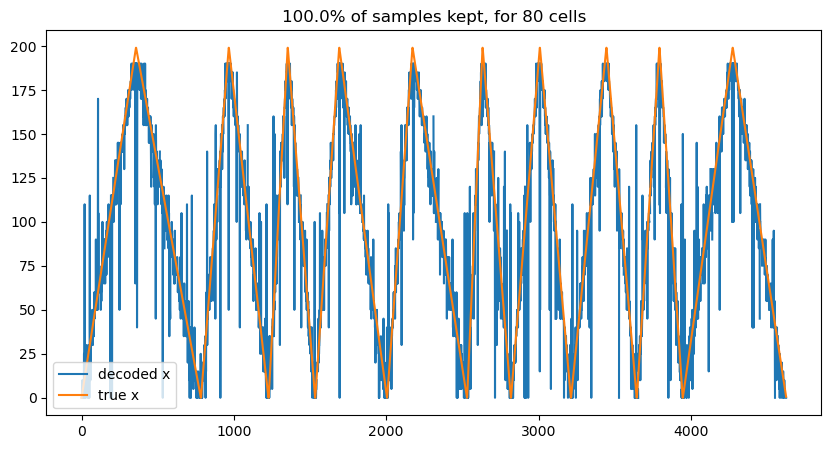

Median error: 4.148235294117626 cm


100%|██████████| 4626/4626 [00:04<00:00, 1021.82it/s]


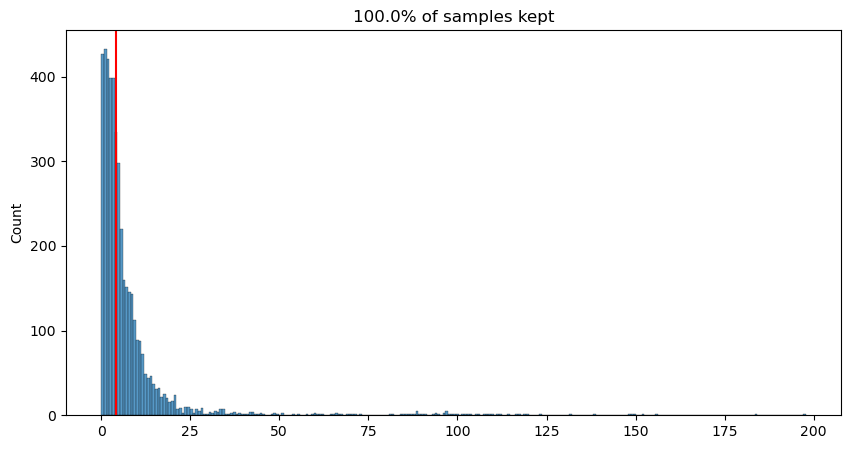

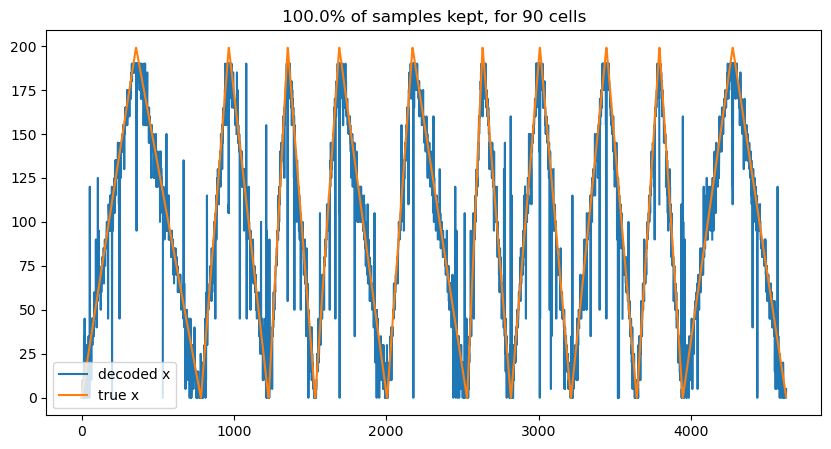

Median error: 3.898906714200834 cm


100%|██████████| 4626/4626 [00:04<00:00, 966.39it/s] 


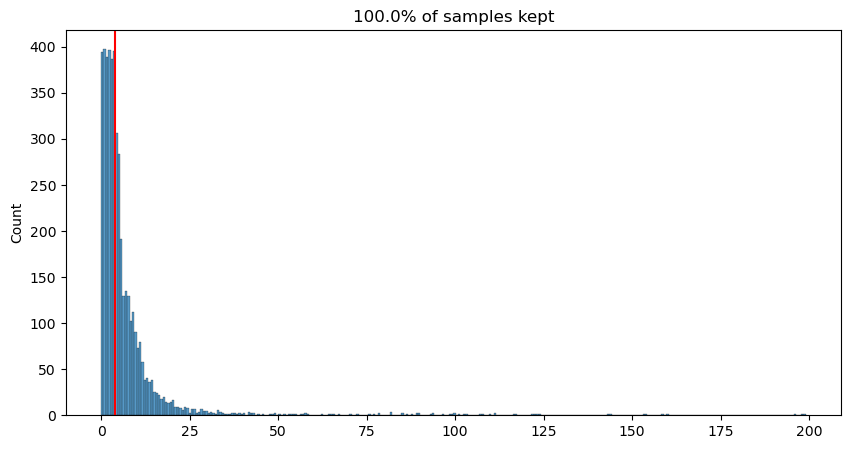

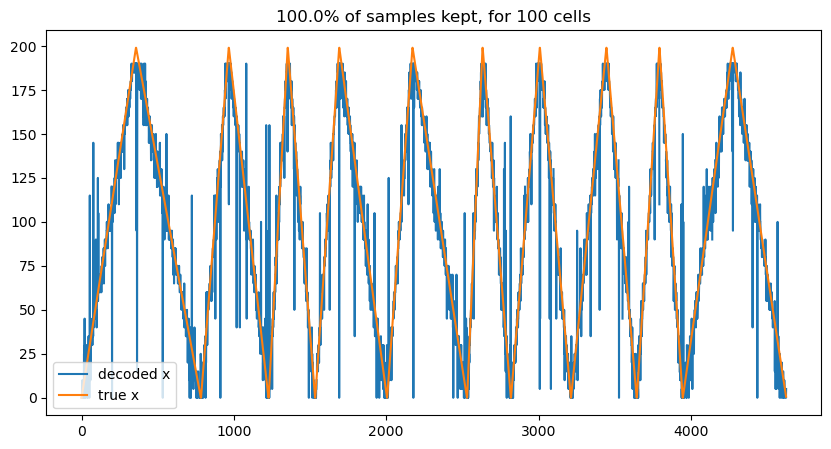

Median error: 3.696485623003184 cm


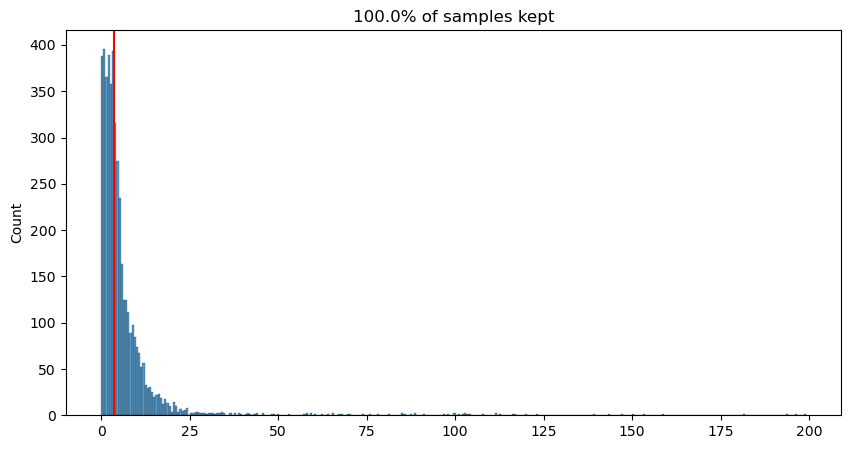

In [9]:
errors = []
fraction_cells = [0.1, 0.2, 0.3,0.4, 0.5, 0.6, 0.7,0.8, 0.9, 1.0]
for fraction in fraction_cells:
    errors.append(decode_subsample(fraction_samples = 1.0, fraction_cells= fraction))

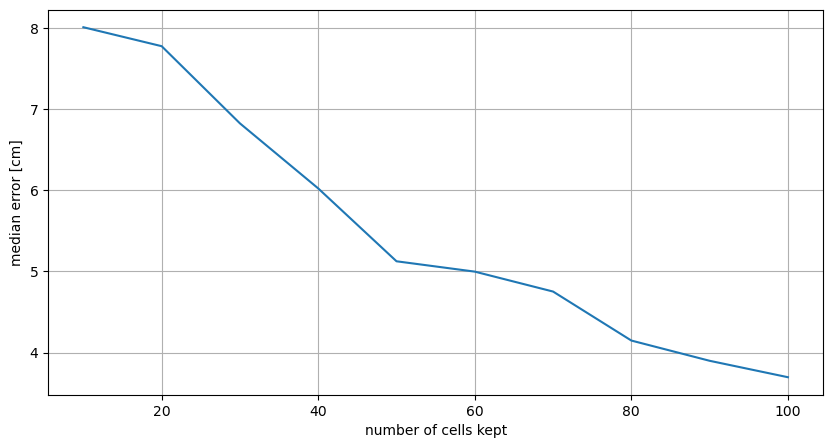

In [10]:
plt.plot(100*np.array(fraction_cells), np.array(errors))
plt.xlabel("number of cells kept")
plt.ylabel("median error [cm]")
plt.grid()

Here, we can see that, as to be expected, the number of cells included improves the performance. 
### C

100%|██████████| 6539/6539 [00:06<00:00, 986.84it/s] 


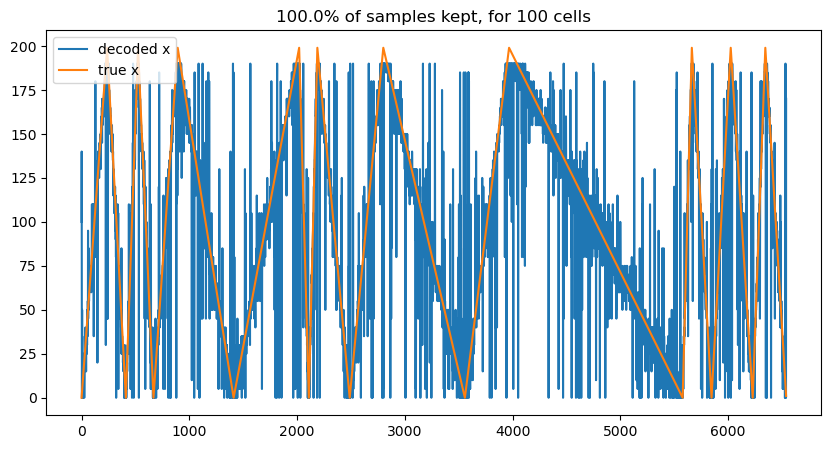

Median error: 4.171334431630967 cm


4.171334431630967

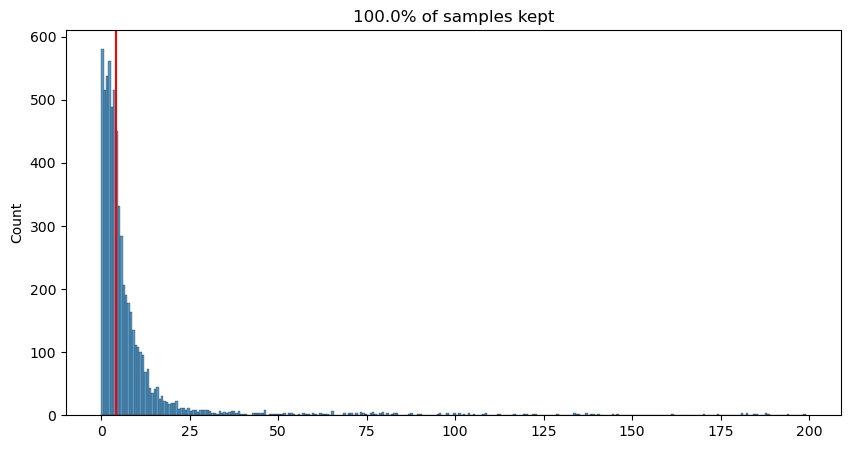

In [11]:
decode_subsample(1.0, 1.0, file_name='data/linear_track_data_noisier.pickle')

Setting the baseline noise to 0.5 significantly degrades the performance, however the effect of this would be much more pronounced if we were to drop some of the neurons, or some of the samples again, as shown below:

100%|██████████| 6539/6539 [00:06<00:00, 1005.28it/s]


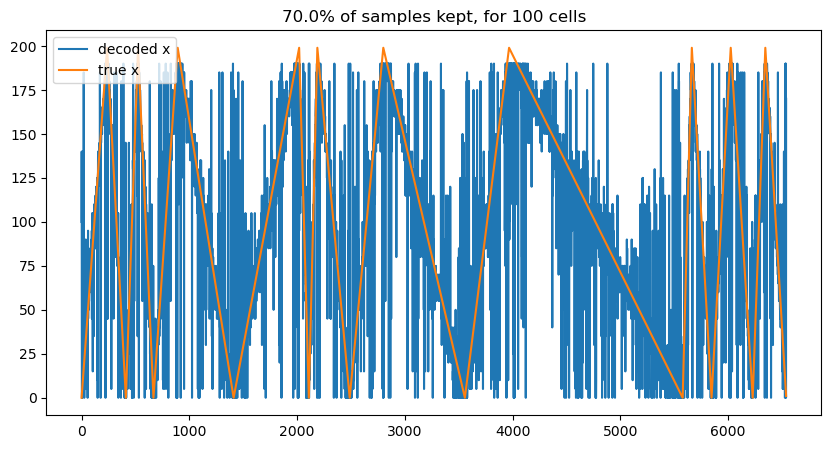

Median error: 4.769357495881394 cm


4.769357495881394

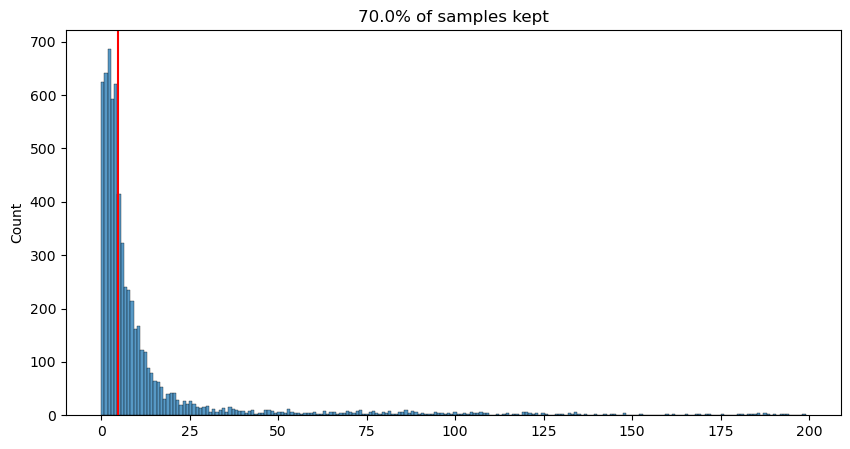

In [12]:
decode_subsample(0.7, 1.0, file_name='data/linear_track_data_noisier.pickle')

Compared to the error of 4.2cm for the original noise term, this is a significant degradation of the accuracy.

100%|██████████| 4626/4626 [00:04<00:00, 1002.90it/s]


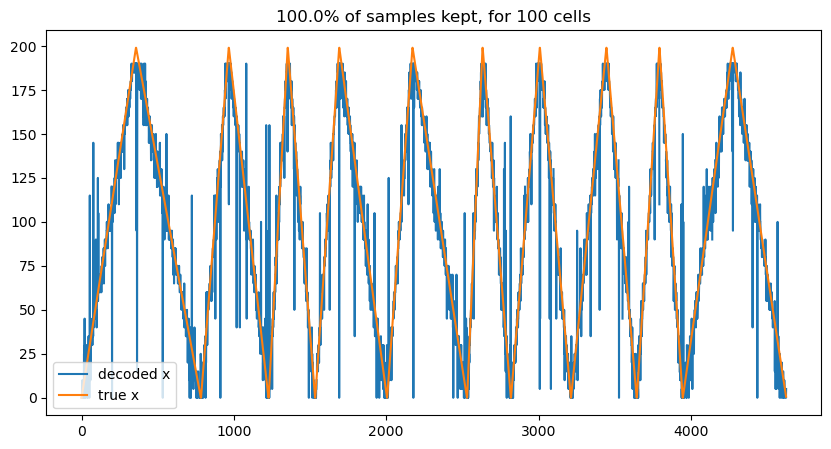

Median error: 3.696485623003184 cm


3.696485623003184

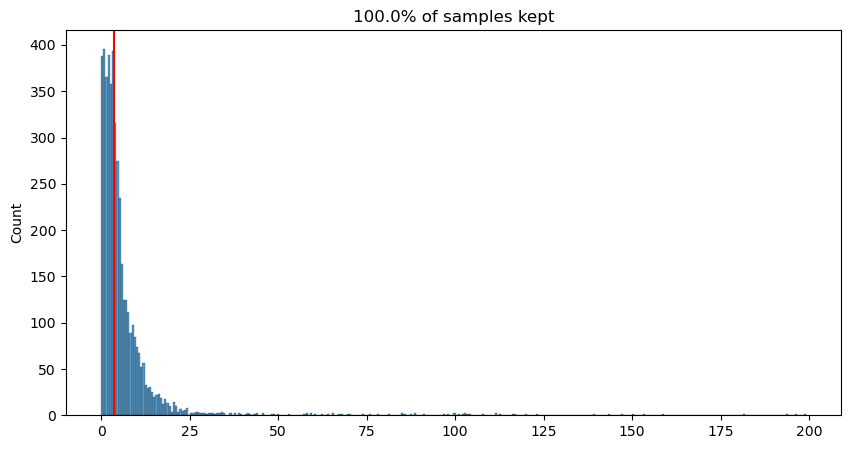

In [13]:
decode_subsample(fraction_samples=1., fraction_cells=1., exercise_2= False)

100%|██████████| 4626/4626 [00:05<00:00, 810.27it/s]


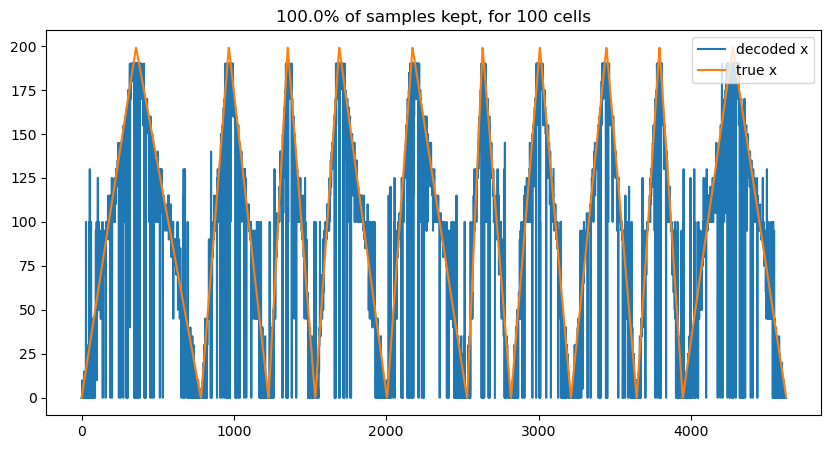

Median error: 6.467787114845947 cm


6.467787114845947

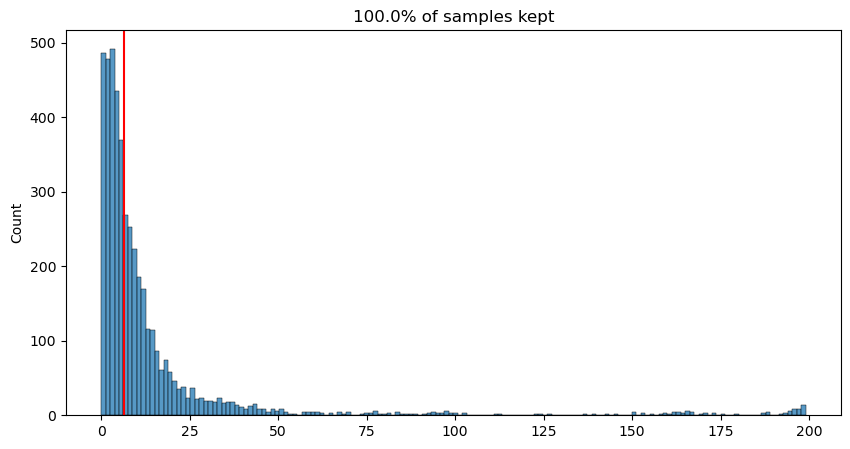

In [14]:
decode_subsample(fraction_samples=1., fraction_cells=1., exercise_2= True)

## Exercise 3

### REMARK: Your code contained some bugs, I believe: You were using spike_count in decoding loop to check for >0, which is not defined in this context, it should have been spikes_sampled instead, which leads to some nan values for x_decoded, which need to be removed for the fitting and the pearson computation, since these cant handle nans.

spikes_sampled shape: (100, 10)
x_decoded: [ nan  nan 115. 115. 130. 130. 135. 110.   0. 140.]
Number of NaNs: 2


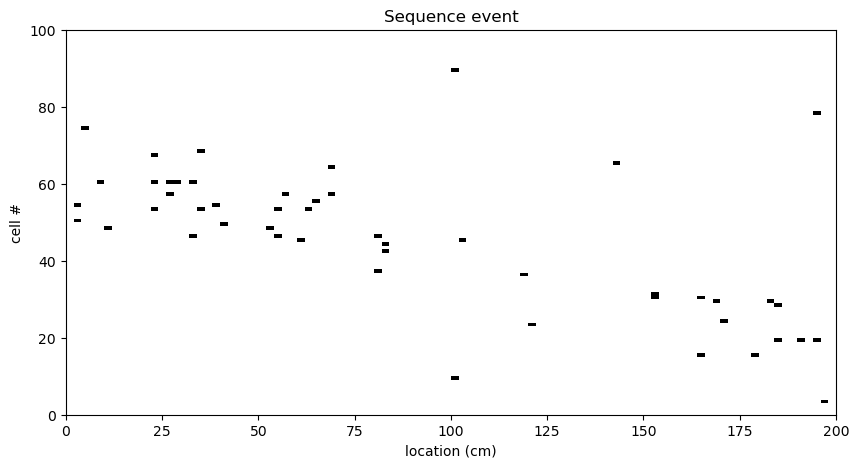

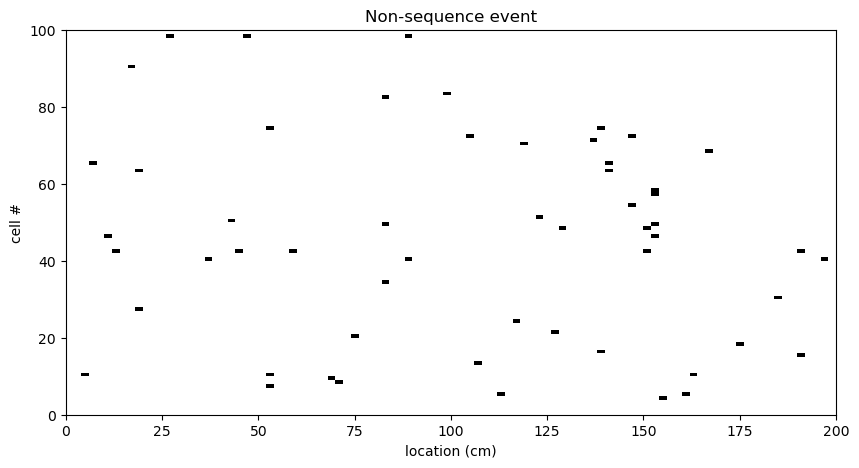

In [15]:
from scipy.stats import pearsonr
#code: data import
data_file = 'data/linear_track_data.pickle'
with open(data_file, 'rb') as handle:
    data = pickle.load(handle)

x,t,spikes = data['x'].copy(),data['t'].copy(),data['spikes'].copy()
track_length = data['track_length']
fps = data['fps'] 
n_cells = len(spikes)

# we compute the poistion at which each spike was emitted
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., track_length, 5.) # binning in bins of 5 cms

# we compute histograms for each cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
spikes_hist = np.asarray(spikes_hist)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 

# generate data 

n_events = 200 # number of reactivation events
event_duration = 100 # in bins
sampling_rate = 100 # sampling rate 
t_react = np.arange(0,100)
noise_x_react=5; # Noise in the reactivation of the sequence
noise_t_react=5; # Noise in the timing of the spikes 
noise_firing_rate = 0.1 # the baseline noise firing rate


reactivation_events = np.zeros((n_events,event_duration))
spikes_react = np.zeros((n_events,n_cells,event_duration))

for event in range(n_events):
    if(event<=n_events//2):
    #Generate "real" sequences for the first half of events
        x_start = np.random.uniform(0,track_length) # Starting point
        x_end = np.random.uniform(0,track_length) # Ending point
        x_react = np.linspace(x_start,x_end,event_duration) \
            +np.random.normal(0,noise_x_react,size=event_duration)

    else:
        #Pick locations randomly for the second half 
        x_react = np.random.uniform(0,track_length,size=event_duration);

    x_react[x_react<0]=0;
    x_react[x_react>track_length]=track_length
    
    #store reactivation sequence
    reactivation_events[event,:] = x_react

    
    # Generate spikes according to the location being reactivated in this event
    
    for i in range(n_cells):
        binned_x = np.digitize(x_react,bins=np.linspace(0,track_length,firing_rate_maps.shape[-1]))-1
        inst_rate = firing_rate_maps[i,binned_x] + np.random.normal(0,noise_firing_rate,size=len(binned_x))
        inst_rate[inst_rate<0] = 0
        spikes_loc = np.where(np.random.poisson(inst_rate/sampling_rate)>0)
        spikes_loc = spikes_loc + np.round(np.random.normal(0,noise_t_react,size=len(spikes_loc)))
        spikes_loc = spikes_loc[np.logical_and(spikes_loc>0,spikes_loc<event_duration)]
        spikes_react[event,i,spikes_loc.astype(int)] = 1
        
    
pfc_idxs = [np.argmax(rate_map) for rate_map in firing_rate_maps] 
sorted_idxs = np.argsort(pfc_idxs)


event = 50
plt.figure(figsize=(10,5))
plt.title('Sequence event')
plt.imshow(spikes_react[event,sorted_idxs,:], cmap='Greys', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')

event = 151
plt.figure(figsize=(10,5))
plt.title('Non-sequence event')
plt.imshow(spikes_react[event,sorted_idxs,:], cmap='Greys', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')

time_window = 10 # number of bins to aggregate during decoding

reactivation_slope = np.zeros(n_events)

for event in range(n_events):

    event_spikes = spikes_react[event]
    # First we bin the events in windows of 10 bins
    spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//time_window))
    # We generate a new spike matrix with the re-sized window
    for t_r in range(1,event_spikes.shape[1]//time_window):
        spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*time_window :(t_r)*time_window],axis=1)

# to do: bayesian decoding
t_resize = 10 # We use spikes from multiple time windows for the decoding

reactivation_slopes = np.zeros(n_events)
reactivation_pvalues = np.zeros(n_events)

for event in range(n_events):

    event_spikes = spikes_react[event]
    spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//t_resize))

    # We generate a new spike matrix with the re-sized window
    for t_r in range(1,event_spikes.shape[1]//t_resize):
        spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*t_resize :(t_r)*t_resize],axis=1)


    # We then perform decoding on the aggregated spikes
    x_decoded = np.zeros(spikes_sampled.shape[1])

    for t_bin in range(spikes_sampled.shape[1]):

        if sum(spikes_sampled[:, t_bin])>0: # Check if the time window contains spikes

            posterior = np.empty(firing_rate_maps.shape[-1])
            for i in range(len(posterior)):
                posterior[i] = sum(poisson.logpmf(spikes_sampled[:,t_bin],firing_rate_maps[:,i]*t_resize/fps)+pow(1,-15))

            x_decoded[t_bin] = space_bins[np.argmax(posterior)]

        else:
            x_decoded[t_bin] = np.nan   

    # We fit a line to the decoded positions, and save the slope
    valid_indices = np.sort(~np.isnan(x_decoded))
    slope,_ = np.polyfit(np.arange(len(x_decoded))[valid_indices],x_decoded[valid_indices],deg=1)
    reactivation_slopes[event] = slope
    # And calculate the pvalue of the pearson correlation
    corr = pearsonr(np.arange(len(x_decoded))[valid_indices],x_decoded[valid_indices])
    reactivation_pvalues[event] = corr[1]

    if event == 0:  # just look at the first event
        print("spikes_sampled shape:", spikes_sampled.shape)
        print("x_decoded:", x_decoded)
        print("Number of NaNs:", np.sum(np.isnan(x_decoded)))


<Axes: ylabel='Count'>

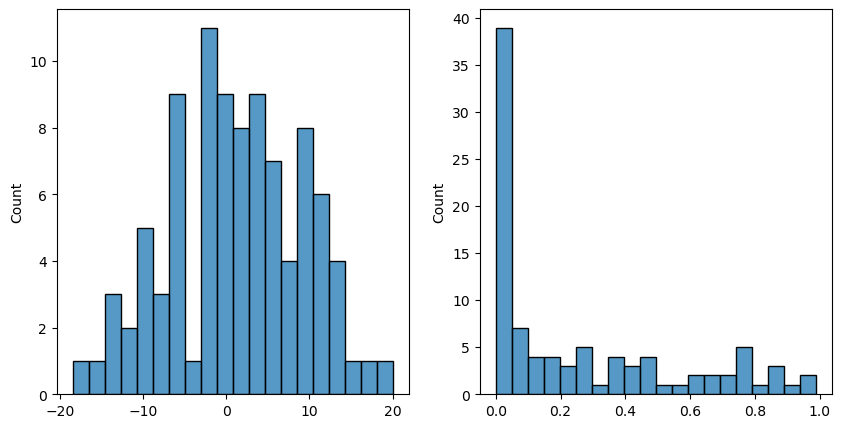

In [16]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.histplot(reactivation_slopes[:100],bins=20)
plt.subplot(1,2,2)
sns.histplot(reactivation_pvalues[:100],bins=20)

<Axes: ylabel='Count'>

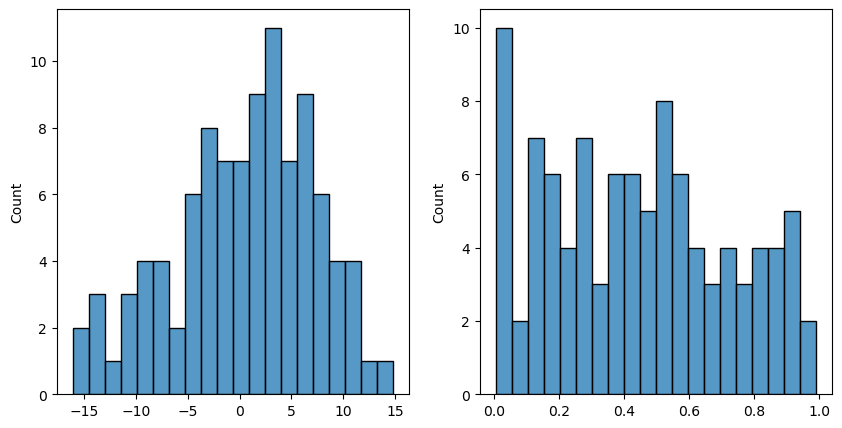

In [17]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.histplot(reactivation_slopes[100:],bins=20)
plt.subplot(1,2,2)
sns.histplot(reactivation_pvalues[100:],bins=20)

To estimate the number of false positives and negatives, we have to set boundary for the slopes to count as non-zeros.


In [18]:
boundary = 2.0
n_fn = np.sum(np.abs(reactivation_slopes[:100])<boundary)
n_fp = np.sum(np.abs(reactivation_slopes[100:])>boundary)
n_fn_p = np.sum(reactivation_pvalues[:100]>0.1)
n_fp_p = np.sum(reactivation_pvalues[100:]<0.1)
print(f"from slopes alone: number of false negatives = {n_fn}, false positives = {n_fp}")
print(f"from p_values alone: number of false negatives = {n_fn_p}, false positives = {n_fp_p}")

from slopes alone: number of false negatives = 17, false positives = 79
from p_values alone: number of false negatives = 48, false positives = 12


We can see that, in virologist-lingo, the "sensitivity" of the slope-based approach is much higher, while the "specificity" of the pvalue based approach is higher.

In [22]:
def run_with_noise(noise_x = 5, noise_t = 5):
    #code: data import
    data_file = 'data/linear_track_data.pickle'
    with open(data_file, 'rb') as handle:
        data = pickle.load(handle)

    x,t,spikes = data['x'].copy(),data['t'].copy(),data['spikes'].copy()
    track_length = data['track_length']
    fps = data['fps'] 
    n_cells = len(spikes)

    # we compute the poistion at which each spike was emitted
    spike_positions = [np.interp(s, t, x) for s in spikes]
    space_bins = np.arange(0., track_length, 5.) # binning in bins of 5 cms

    # we compute histograms for each cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps

    firing_rate_maps = spikes_hist / occupancy 

    # generate data 

    n_events = 200 # number of reactivation events
    event_duration = 100 # in bins
    sampling_rate = 100 # sampling rate 
    t_react = np.arange(0,100)
    noise_x_react=noise_x; # Noise in the reactivation of the sequence
    noise_t_react=noise_t; # Noise in the timing of the spikes 
    noise_firing_rate = 0.1 # the baseline noise firing rate


    reactivation_events = np.zeros((n_events,event_duration))
    spikes_react = np.zeros((n_events,n_cells,event_duration))

    for event in range(n_events):
        if(event<=n_events//2):
        #Generate "real" sequences for the first half of events
            x_start = np.random.uniform(0,track_length) # Starting point
            x_end = np.random.uniform(0,track_length) # Ending point
            x_react = np.linspace(x_start,x_end,event_duration) \
                +np.random.normal(0,noise_x_react,size=event_duration)

        else:
            #Pick locations randomly for the second half 
            x_react = np.random.uniform(0,track_length,size=event_duration);

        x_react[x_react<0]=0;
        x_react[x_react>track_length]=track_length
        
        #store reactivation sequence
        reactivation_events[event,:] = x_react

        
        # Generate spikes according to the location being reactivated in this event
        
        for i in range(n_cells):
            binned_x = np.digitize(x_react,bins=np.linspace(0,track_length,firing_rate_maps.shape[-1]))-1
            inst_rate = firing_rate_maps[i,binned_x] + np.random.normal(0,noise_firing_rate,size=len(binned_x))
            inst_rate[inst_rate<0] = 0
            spikes_loc = np.where(np.random.poisson(inst_rate/sampling_rate)>0)
            spikes_loc = spikes_loc + np.round(np.random.normal(0,noise_t_react,size=len(spikes_loc)))
            spikes_loc = spikes_loc[np.logical_and(spikes_loc>0,spikes_loc<event_duration)]
            spikes_react[event,i,spikes_loc.astype(int)] = 1
            
        
    pfc_idxs = [np.argmax(rate_map) for rate_map in firing_rate_maps] 
    sorted_idxs = np.argsort(pfc_idxs)


    # event = 50
    # plt.figure(figsize=(10,5))
    # plt.title('Sequence event')
    # plt.imshow(spikes_react[event,sorted_idxs,:], cmap='Greys', extent = [0, 200, 0, n_cells])
    # plt.xlabel('location (cm)')
    # plt.ylabel('cell #')

    # event = 151
    # plt.figure(figsize=(10,5))
    # plt.title('Non-sequence event')
    # plt.imshow(spikes_react[event,sorted_idxs,:], cmap='Greys', extent = [0, 200, 0, n_cells])
    # plt.xlabel('location (cm)')
    # plt.ylabel('cell #')

    time_window = 10 # number of bins to aggregate during decoding

    reactivation_slope = np.zeros(n_events)

    for event in range(n_events):

        event_spikes = spikes_react[event]
        # First we bin the events in windows of 10 bins
        spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//time_window))
        # We generate a new spike matrix with the re-sized window
        for t_r in range(1,event_spikes.shape[1]//time_window):
            spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*time_window :(t_r)*time_window],axis=1)

    # to do: bayesian decoding
    t_resize = 10 # We use spikes from multiple time windows for the decoding

    reactivation_slopes = np.zeros(n_events)
    reactivation_pvalues = np.zeros(n_events)

    for event in range(n_events):

        event_spikes = spikes_react[event]
        spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//t_resize))

        # We generate a new spike matrix with the re-sized window
        for t_r in range(1,event_spikes.shape[1]//t_resize):
            spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*t_resize :(t_r)*t_resize],axis=1)


        # We then perform decoding on the aggregated spikes
        x_decoded = np.zeros(spikes_sampled.shape[1])

        for t_bin in range(spikes_sampled.shape[1]):

            if sum(spikes_sampled[:, t_bin])>0: # Check if the time window contains spikes

                posterior = np.empty(firing_rate_maps.shape[-1])
                for i in range(len(posterior)):
                    posterior[i] = sum(poisson.logpmf(spikes_sampled[:,t_bin],firing_rate_maps[:,i]*t_resize/fps)+pow(1,-15))

                x_decoded[t_bin] = space_bins[np.argmax(posterior)]

            else:
                x_decoded[t_bin] = np.nan   

        # We fit a line to the decoded positions, and save the slope
        valid_indices = np.sort(~np.isnan(x_decoded))
        slope,_ = np.polyfit(np.arange(len(x_decoded))[valid_indices],x_decoded[valid_indices],deg=1)
        reactivation_slopes[event] = slope
        # And calculate the pvalue of the pearson correlation
        corr = pearsonr(np.arange(len(x_decoded))[valid_indices],x_decoded[valid_indices])
        reactivation_pvalues[event] = corr[1]

    boundary = 2.0
    n_fn = np.sum(np.abs(reactivation_slopes[:100])<boundary)
    n_fp = np.sum(np.abs(reactivation_slopes[100:])>boundary)
    n_fn_p = np.sum(reactivation_pvalues[:100]>0.1)
    n_fp_p = np.sum(reactivation_pvalues[100:]<0.1)
    return np.array([n_fn, n_fp, n_fn_p, n_fp_p])
    

/var/folders/1_/jd84lw7d3qd408fwkk21ctvc0000gn/T/ipykernel_46572/761558997.py:138: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = pearsonr(np.arange(len(x_decoded))[valid_indices],x_decoded[valid_indices])


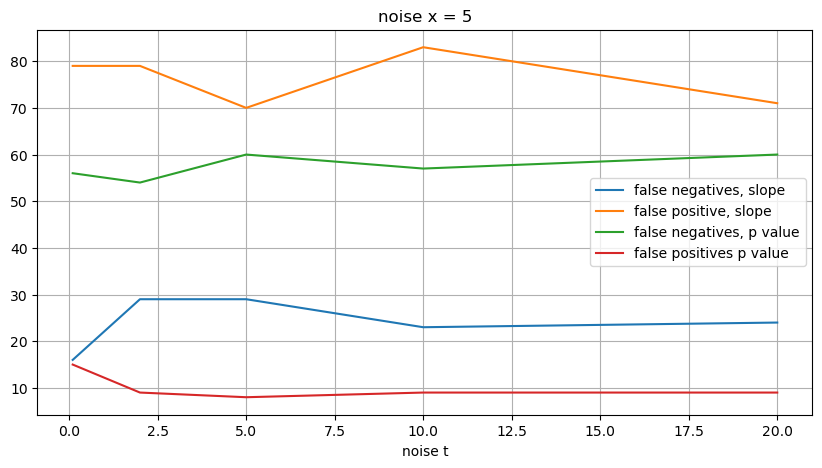

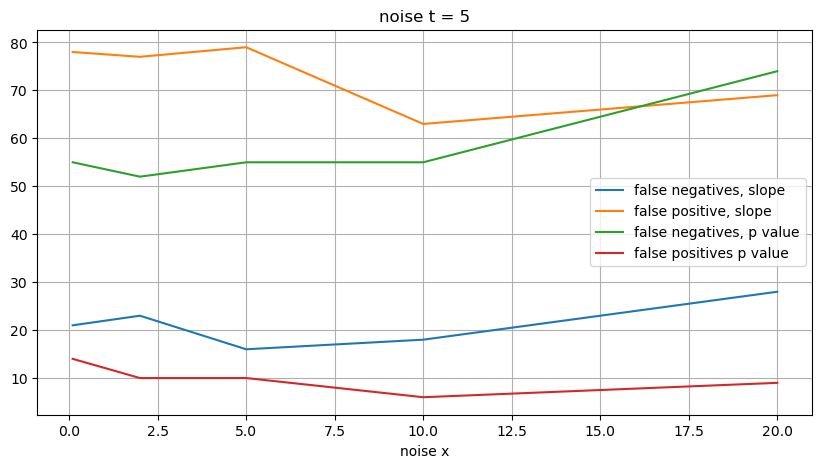

In [31]:

metric = np.zeros((5,4))
for i, noise_t in enumerate([0.1, 2., 5., 10., 20]):
    metric[i, :] = run_with_noise(5, noise_t)
plt.title(f"noise x = {5}")
plt.plot([0.1, 2., 5., 10., 20],metric[:, 0], label =  "false negatives, slope")
plt.plot([0.1, 2., 5., 10., 20],metric[:, 1], label = "false positive, slope")
plt.plot([0.1, 2., 5., 10., 20],metric[:, 2], label = "false negatives, p value")
plt.plot([0.1, 2., 5., 10., 20],metric[:, 3], label = "false positives p value")
plt.xlabel("noise t")
plt.legend()
plt.grid()
plt.show()

metric = np.zeros((5,4))
for i, noise_t in enumerate([0.1, 2., 5., 10., 20.]):
    metric[i, :] = run_with_noise(noise_t, 5.)
plt.title(f"noise t = {5}")
plt.plot([0.1, 2., 5., 10., 20],metric[:, 0], label =  "false negatives, slope")
plt.plot([0.1, 2., 5., 10., 20],metric[:, 1], label = "false positive, slope")
plt.plot([0.1, 2., 5., 10., 20],metric[:, 2], label = "false negatives, p value")
plt.plot([0.1, 2., 5., 10., 20],metric[:, 3], label = "false positives p value")
plt.xlabel("noise x")
plt.legend()
plt.grid()
plt.show()

While I have also used the slope of the fit as an indicator, this is obviously problematic for sequences which have a small slope but are not random as they will fail the criterion, independent of the noise. We can assume that much higher noise terms in x will lead to an increase in false negatives, as more sequences will be dominated by the randomness. Noise terms in t do not seem to influence the results as much, even though they should have lead to higher p values as well.

### C

Generally, we will not recognize sequences with very small slopes, as they will be dominated by the noise terms and appear random. Sequences with a sufficiently strong drift will be more easily recognized by both slope based and p value based detection. A possible way to deal with this, would be to have an adaptive boundary for the p values, dependent on the slope being fit. Furthermore, our approach relies entirely on linear trajectories, which migh be unrealistic.

While there will always be trade-offs for different techniques, I could think of at least one other approach:
We could you autocorrelation and crosscorrelation between cells with adjacent place fields. For sequences, the spectral power density would have some sort of structure, while for white noise it would just be constant (or something else for different noise), furthermore, the cross-correlation between adjacent placecells would be high for sequences, while it would be much lower for randomly generated activity.